# Flexibility in a Search Model 

## Model

- homogeneous workers with linear utility over wage $w(x;k)$ if employed and flow (dis)utility $b$ if unemployed
- heterogeneous firms endowed with flexibility level $k \in K = \{1,2,3\}$ costing $c(k)$ with linear profit $y(x;k)-w(x;k)-c(k)$
    - current assumption: $y(x;k) = kx$
- search parameters: discount rate $\rho$, unemployed meet firms at rate $\lambda$ (no on-the-job search), upon meeting draw match-specific productivity $x \sim G(x)$, bargaining parameter $\alpha$, employed face separation shock $\eta$


## Necessary Packages

In [1]:
# General
import numpy as np
import pandas as pd 
import scipy.stats as stats

# Graphics
import matplotlib.pyplot as plt 
import seaborn as sns

# Estimation
from scipy.optimize import minimize


## Data 
- employed workers earn wage $w_i$ at firm with flexibility level $k$
- unemployed workers have unemployment durations of $t_i$
- flexibility level $k$ defined by 
    - 0: No flexibility in start and end times of work 
    - 1: Informal policy allowing flexibility in start and end times of work
    - 2: Formal policy allowing for flexibility in start and end times of work

In [2]:
df=pd.read_stata('workfile.dta', columns=['sex','employed', 'flex_sched_score', 'hrwage', 'dur']) #986,337 obs from 1984-2017; 711,205 for 2000-2017

In [3]:
df['flex']=np.NaN
df['flex'].iloc[(df['flex_sched_score']==0)] = 0
df['flex'].iloc[(df['flex_sched_score']==1 )| (df['flex_sched_score']==2)] = 1

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
df['flex_sched_score'].value_counts()

1.0    1219
0.0     829
2.0     406
Name: flex_sched_score, dtype: int64

In [5]:
df['flex'].value_counts()

1.0    1625
0.0     829
Name: flex, dtype: int64

In [6]:
df['flex_sched_score'].groupby(df['sex']).value_counts(normalize=True)

sex     flex_sched_score
male    1.0                 0.547504
        0.0                 0.274557
        2.0                 0.177939
female  1.0                 0.444719
        0.0                 0.402640
        2.0                 0.152640
Name: flex_sched_score, dtype: float64

In [7]:
df['employed'].value_counts()

1.0    2454
0.0      54
Name: employed, dtype: int64

In [8]:
men = df[df['sex']=='male']
len(men)

1269

In [9]:
women = df[df['sex']=='female']
len(women)

1239

In [10]:
men['employed'].value_counts()

1.0    1242
0.0      27
Name: employed, dtype: int64

In [11]:
men['hrwage'].describe()

count    1242.000000
mean       42.517616
std        18.955248
min         0.008000
25%        26.923000
50%        39.423000
75%        58.173000
max        72.115250
Name: hrwage, dtype: float64

In [12]:
men['dur'].describe()

count     27.000000
mean      18.629629
std       23.348774
min        8.000000
25%       12.000000
50%       12.000000
75%       16.000000
max      131.000000
Name: dur, dtype: float64

## Functions

In [13]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*np.pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [14]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculated lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

In [15]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 

    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [16]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

    return λ*prob_sum

In [17]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: float of observed minimum wage
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: location parameter of the log-normal wage distribution
    - σ: scale parameter of the log-normal wage distribution
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

In [18]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 10
η = 10

# Men

## Flexible Schedule Score

In [68]:
fifth_pctl = np.zeros(1)

for k in range(3):
    tmp = men[men['flex_sched_score']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.49037504196167 for men with flex level 1
5th percentile wage = 18.0 for men with flex level 2


In [69]:
fifth_pctl[1:]

array([13.        , 17.49037504, 18.        ])

In [70]:
men['wage_trunc3']=men['hrwage']

for k in range(3):
    men['wage_trunc3'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/4041549448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc3']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
men['wage_trunc3'].groupby([men['employed'],men['flex_sched_score']]).describe()

count       mean        std        min     25%  \
employed flex_sched_score                                                   
1.0      0.0               341.0  35.949913  17.789873  13.000000  22.500   
         1.0               680.0  45.039341  18.127398  17.490376  30.000   
         2.0               221.0  46.191139  18.594522  18.000000  30.048   

                                 50%        75%       max  
employed flex_sched_score                                  
1.0      0.0               31.250000  47.115250  72.11525  
         1.0               43.269001  61.538250  72.11525  
         2.0               43.748001  64.903748  72.11525

In [72]:
men['flex_sched_score'].value_counts(normalize=True, sort=False)

1.0    0.547504
0.0    0.274557
2.0    0.177939
Name: flex_sched_score, dtype: float64

In [73]:
prob_k = np.array([0.274557, 0.547504, 0.177939])

In [74]:
params = np.array([c_k[1], c_k[2], λ, η, men['wage_trunc3'].mean(), men['wage_trunc3'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'wage_trunc3', 'dur', men['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:26: RuntimeWarning: invalid value encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:26: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() 

In [75]:
est4.success

True

In [76]:
est4.x

array([2.29759182e+01, 3.81659796e+01, 5.55469736e-02, 1.16855848e-03,
       3.77626280e+00, 5.09872940e-01])

In [77]:
est4.fun

5632.288931457506

In [78]:
params = np.array([c_k[1], c_k[2], λ, η, men['hrwage'].mean(), men['hrwage'].std()])

logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage', 'dur', men['hrwage'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:26: RuntimeWarning: divide by zero encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )


In [79]:
est3.success

True

In [80]:
est3.x

array([2.30207282e+01, 5.20975683e+01, 5.46495517e-02, 1.18026386e-03,
       3.95810647e+00, 6.09354521e-01])

In [81]:
est3.fun

5946.3643180559675

## Binary Flexibility

In [82]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = men[men['flex']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 13.0 for men with flex level 0
5th percentile wage = 17.5 for men with flex level 1


In [83]:
fifth_pctl[1:]

array([13. , 17.5])

In [84]:
men['wage_trunc2']=men['hrwage']

for k in range(2):
    men['wage_trunc2'].iloc[(men['hrwage']<fifth_pctl[k+1]) & (men['flex']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3523321040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men['wage_trunc2']=men['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [85]:
men['flex'].value_counts(normalize=True, sort=False)

1.0    0.725443
0.0    0.274557
Name: flex, dtype: float64

In [97]:
prob_k = np.array([0.274557, 0.725443])

In [108]:
params = np.array([c_k[1], λ, η, men['wage_trunc2'].mean(), men['wage_trunc2'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'wage_trunc2', 'dur', men['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )


In [110]:
est2.success

True

In [111]:
est2.x

array([ 3.46480288e+01,  4.61920859e+02,  1.05592094e-02, -8.86758274e+00,
        3.49275542e+00])

In [112]:
est2.fun

6083.925117626784

In [113]:
params = np.array([c_k[1], λ, η, men['hrwage'].mean(), men['hrwage'].std()])

logL_opt = lambda x: log_L(men, 'flex', 'hrwage', 'dur', men['hrwage'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/2086801216.py:6: RuntimeWarning: invalid value encountered in log
  lnx = np.log(x)


In [114]:
est1.success

True

In [115]:
est1.x

array([ 2.82994768e-01,  1.54969812e-01,  1.18474734e-03, -1.04585394e+01,
        2.02693432e+01])

In [116]:
est1.fun

8630.012142735199

# Women

## Flexible Schedule Score

In [117]:
fifth_pctl = np.zeros(1)

for k in range(3):
    tmp = women[women['flex_sched_score']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 10.434999752044678 for men with flex level 0
5th percentile wage = 12.982499980926514 for men with flex level 1
5th percentile wage = 12.06520004272461 for men with flex level 2


In [118]:
fifth_pctl[1:]

array([10.43499975, 12.98249998, 12.06520004])

In [119]:
women['wage_trunc3']=women['hrwage']

for k in range(3):
    women['wage_trunc3'].iloc[(women['hrwage']<fifth_pctl[k+1]) & (women['flex_sched_score']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/1623458710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['wage_trunc3']=women['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [120]:
women['wage_trunc3'].groupby([women['employed'],women['flex_sched_score']]).describe()

count       mean        std        min       25%  \
employed flex_sched_score                                                     
1.0      0.0               488.0  29.081598  14.835706  10.434999  18.75000   
         1.0               539.0  37.236629  17.382296  12.982500  23.77875   
         2.0               185.0  34.797462  16.732208  12.065200  21.90000   

                                 50%        75%       max  
employed flex_sched_score                                  
1.0      0.0               25.793250  35.607564  72.11525  
         1.0               33.750000  48.076752  72.11525  
         2.0               31.730749  44.711498  72.11525

In [121]:
women['flex_sched_score'].value_counts(normalize=True, sort=False)

0.0    0.402640
1.0    0.444719
2.0    0.152640
Name: flex_sched_score, dtype: float64

In [122]:
prob_k = np.array([0.402640, 0.444719, 0.152640])

In [123]:
women['wage_trunc3'].min()

10.434999

In [124]:
params = np.array([c_k[1], c_k[2], λ, η, women['wage_trunc3'].mean(), women['wage_trunc3'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'wage_trunc3', 'dur', women['wage_trunc3'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est4 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: divide by zero encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:26: RuntimeWarning: invalid value encountered in log
  empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.log( hazard(res_wa

c_1 = 5, c_2 = 10

In [125]:
est4.success

True

In [126]:
est4.x

array([-2.98922439e+00,  5.45269953e+01,  5.98519001e-02,  1.22882864e-03,
        3.37157812e+00,  6.83956045e-01])

In [127]:
est4.fun

5248.435472221374

c_1 = 1, c_2 = 2

In [68]:
est4.success

True

In [69]:
est4.x

array([ 3.67412238e+00,  7.96151785e+00,  9.60295505e+00,  1.64965460e-03,
       -7.23992085e+00,  3.84502514e+00])

In [70]:
est4.fun

5665.5172794368655

In [128]:
params = np.array([c_k[1], c_k[2], λ, η, women['hrwage'].mean(), women['hrwage'].std()])

logL_opt = lambda x: log_L(women, 'flex_sched_score', 'hrwage', 'dur', women['hrwage'].min(), 
                            np.array([0,x[0],x[1]]), prob_k, 0.5, x[2], x[3],
                            x[4], x[5])

est3 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)


In [129]:
est3.success

True

In [130]:
est3.x

array([ 1.14316903e+01,  5.89798600e+00,  2.12535058e+01,  1.81090224e-03,
       -3.64666156e+01,  1.31265011e+01])

In [131]:
est3.fun

7363.2001584672935

## Binary Flexibility

In [132]:
fifth_pctl = np.zeros(1)

for k in range(2):
    tmp = women[women['flex']==k]
    fifth = np.percentile(tmp['hrwage'],5)
    fifth_pctl = np.append(fifth_pctl, fifth)
    print("5th percentile wage = " + str(fifth) + " for men with flex level " + str(k))

5th percentile wage = 10.434999752044678 for men with flex level 0
5th percentile wage = 12.5 for men with flex level 1


In [133]:
fifth_pctl[1:]

array([10.43499975, 12.5       ])

In [134]:
women['wage_trunc2']=women['hrwage']

for k in range(2):
    women['wage_trunc2'].iloc[(women['hrwage']<fifth_pctl[k+1]) & (women['flex']==k)]=fifth_pctl[k+1] #k+1 because empty array initiates with zero
        

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/93239972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women['wage_trunc2']=women['hrwage']
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [135]:
women['flex'].value_counts(normalize=True, sort=False)

0.0    0.40264
1.0    0.59736
Name: flex, dtype: float64

In [157]:
prob_k = np.array([0.40264, 0.59736])

In [159]:
params = np.array([c_k[1], λ, η, women['wage_trunc2'].mean(), women['wage_trunc2'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'wage_trunc2', 'dur', women['wage_trunc2'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est2 = minimize(logL_opt, params, method='Nelder-Mead', options={'maxiter':8000})

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)


In [ ]:
women['wage']

In [160]:
est2.success

True

In [161]:
est2.x

array([ 1.28227742e-02,  2.98932583e+01,  1.57677674e-03, -1.16599554e+01,
        4.80277697e+00])

In [162]:
est2.fun

5731.530416098112

In [163]:
params = np.array([c_k[1], λ, η, women['hrwage'].mean(), women['hrwage'].std()])

logL_opt = lambda x: log_L(women, 'flex', 'hrwage', 'dur', women['hrwage'].min(), 
                            np.array([0,x[0]]), prob_k, 0.5, x[1], x[2],
                            x[3],x[4])

est1 = minimize(logL_opt, params, method='Nelder-Mead')

/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:23: RuntimeWarning: invalid value encountered in log
  N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:28: RuntimeWarning: invalid value encountered in log
  Nu_log_η = data[dur].count() * np.log(η)
/var/folders/jx/dqj4zyfx4cj4t_bvpvt2drrm0000gn/T/ipykernel_2098/3024392470.py:24: RuntimeWarning: invalid value encountered in log
  N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )


In [164]:
est1.success

True

In [165]:
est1.x

array([ 3.51810009e+00,  1.89677266e+01,  1.60630050e-03, -4.14016322e+01,
        1.48686975e+01])

In [166]:
est1.fun

7439.750918519739

In [95]:
len(women)

1239

# Figures

## Flex Schedule Score (k = 3)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Men with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_3flex.png', bbox_inches='tight', transparent=True)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

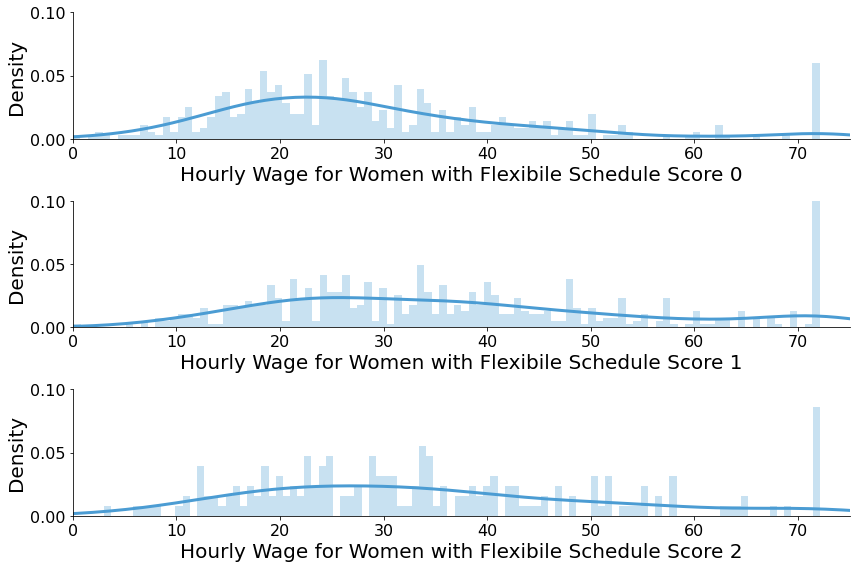

In [80]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_women_3flex.png', bbox_inches='tight', transparent=True)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

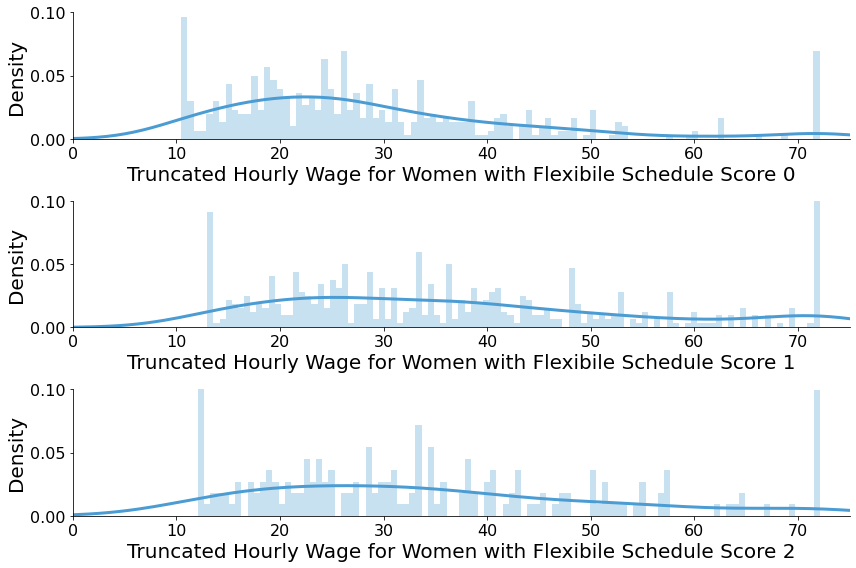

In [81]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = women[(women['flex_sched_score']==k) & (women['employed']==1)]
    sns.distplot(tmp['wage_trunc3'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexibile Schedule Score ' +str(k))

#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

fig.savefig('./wageTrunc_women_3flex.png', bbox_inches='tight', transparent=True)

## Binary Flexibility Measure

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='male') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_men_2flex.png', bbox_inches='tight', transparent=True)

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


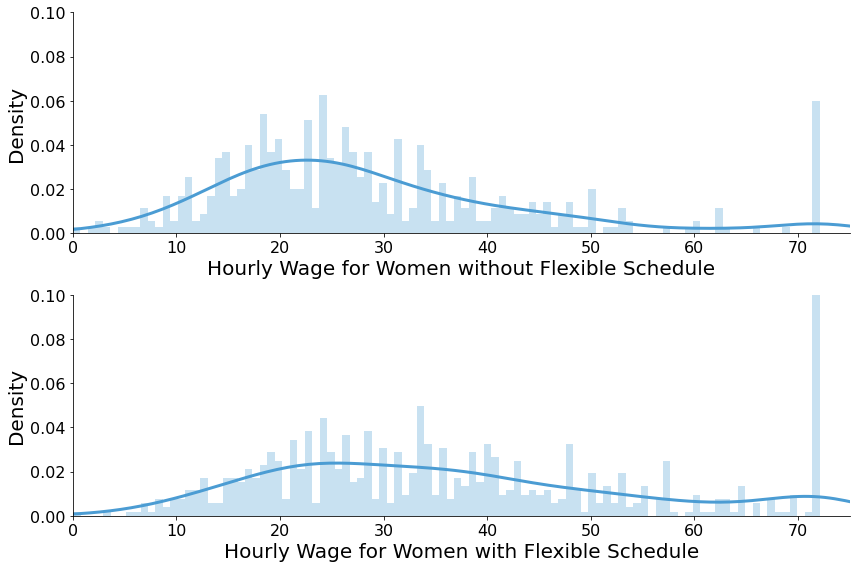

In [77]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = df[(df['flex']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./hrwage_women_2flex.png', bbox_inches='tight', transparent=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = men[(men['flex']==k) & (men['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Men without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_men_2flex.png', bbox_inches='tight', transparent=True)

KeyError: 'wage_trunc2'

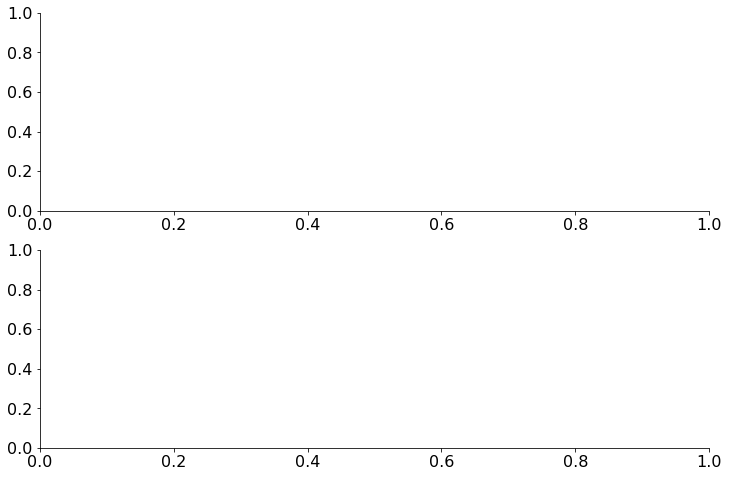

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for k in range(2):
    tmp = women[(women['flex']==k) & (women['employed']==1)] #(df['sex']=='male') & 
    sns.distplot(tmp['wage_trunc2'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
#     ax[k].legend(['Flexibility Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])
    if k == 1:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women with Flexible Schedule')
    elif k == 0:
        ax[k].set(xlabel = 'Truncated Hourly Wage for Women without Flexible Schedule')
    else:
        print("Not binary k")

# ax.set(xlabel="Distribution of Men's Hourly Wage (raw)")

plt.tight_layout()

fig.savefig('./wagetrunc_women_2flex.png', bbox_inches='tight', transparent=True)

# Summary Statistics

In [55]:
agg_dict_empl_3 = {
    'hrwage': ['count', 'min', 'mean', 'std'],
    'wage_trunc3': ['min', 'mean', 'std']
}

agg_dict_empl_2 = {
    'hrwage': ['count', 'min', 'mean', 'std'],
    'wage_trunc2': ['min', 'mean', 'std']
}

agg_dict_unempl = {
    'dur': ['count', 'min', 'max', 'mean', 'std']
}

agg_dict_pos = {
    'flex_sched_score': ['count'] #want to add percent!
}

### Men

In [43]:
print(men.groupby(['flex_sched_score']).agg(agg_dict_empl_3).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{hrwage} & \multicolumn{3}{l}{wage\_trunc3} \\
{} &  count &  min &  mean &   std &         min &  mean &   std \\
flex\_sched\_score &        &      &       &       &             &       &       \\
\midrule
0.0              &    341 & 0.01 & 35.78 & 18.04 &       13.00 & 35.95 & 17.79 \\
1.0              &    680 & 1.02 & 44.76 & 18.61 &       17.49 & 45.04 & 18.13 \\
2.0              &    221 & 9.62 & 46.01 & 18.89 &       18.00 & 46.19 & 18.59 \\
\bottomrule
\end{tabular}



In [99]:
print(men.groupby(['flex']).agg(agg_dict_empl_2).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{hrwage} & \multicolumn{4}{l}{wage\_trunc2} \\
{} &    min &  mean &   std &         min &  mean &   std & count \\
flex &        &       &       &             &       &       &       \\
\midrule
0.0  &   0.01 & 35.78 & 18.04 &       13.00 & 35.95 & 17.79 &   341 \\
1.0  &   1.02 & 45.07 & 18.68 &       17.50 & 45.32 & 18.25 &   901 \\
\bottomrule
\end{tabular}



In [52]:
print(men.agg(agg_dict_unempl).to_latex()) # by gender

\begin{tabular}{lr}
\toprule
{} &        dur \\
\midrule
count &  27.000000 \\
mean  &  18.629629 \\
std   &  23.348774 \\
\bottomrule
\end{tabular}



### Women

In [44]:
print(women.groupby(['flex_sched_score']).agg(agg_dict_empl_3).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{hrwage} & \multicolumn{3}{l}{wage\_trunc3} \\
{} &  count &  min &  mean &   std &         min &  mean &   std \\
flex\_sched\_score &        &      &       &       &             &       &       \\
\midrule
0.0              &    488 & 0.02 & 28.90 & 15.09 &       10.43 & 29.08 & 14.84 \\
1.0              &    539 & 0.05 & 37.08 & 17.62 &       12.98 & 37.24 & 17.38 \\
2.0              &    185 & 3.00 & 34.62 & 17.00 &       12.07 & 34.80 & 16.73 \\
\bottomrule
\end{tabular}



In [45]:
print(women.groupby(['flex']).agg(agg_dict_empl_2).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{hrwage} & \multicolumn{3}{l}{wage\_trunc2} \\
{} &  count &  min &  mean &   std &         min &  mean &   std \\
flex &        &      &       &       &             &       &       \\
\midrule
0.0  &    488 & 0.02 & 28.90 & 15.09 &       10.43 & 29.08 & 14.84 \\
1.0  &    724 & 0.05 & 36.45 & 17.49 &       12.50 & 36.60 & 17.26 \\
\bottomrule
\end{tabular}



In [46]:
print(women.agg(agg_dict_unempl).to_latex()) # by gender

\begin{tabular}{lr}
\toprule
{} &        dur \\
\midrule
mean  &  18.111111 \\
std   &  22.859661 \\
count &  27.000000 \\
\bottomrule
\end{tabular}



In [56]:
print(df.groupby(df['sex']).agg(agg_dict_unempl).to_latex(float_format="%.2f")) # by gender

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{dur} \\
{} & count &  min &    max &  mean &   std \\
sex    &       &      &        &       &       \\
\midrule
male   &    27 & 8.00 & 131.00 & 18.63 & 23.35 \\
female &    27 & 8.00 & 129.00 & 18.11 & 22.86 \\
\bottomrule
\end{tabular}



In [ ]:
print(empl_df.groupby(['female']).agg(agg_dict_empl).to_latex()) # all

In [ ]:
print(unempl_df.agg(agg_dict_unempl).to_latex()) # by gender

# Scratch

In [ ]:
# Parameters to be estimated 

c_k = np.array([0,5,10])
λ = 2.1
η = 2.1
μ = men['hrwage'].groupby(men['flex_sched_score']).mean().values
σ = men['hrwage'].groupby(men['flex_sched_score']).std().values

In [ ]:
logL_opt = lambda x: log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            x[0], prob_k, 0.5, x[1], x[2],
                            x[3], x[4])

In [ ]:
params = np.array([c_k, float(λ), float(η), μ, σ])
params

In [ ]:
params[1]

In [ ]:
log_L(men, 'flex_sched_score', 'hrwage', 'dur', Uk, 
                            params[0], prob_k, 0.5, params[1], params[2],
                            params[3], params[4])

In [ ]:
logL_opt(params)

## Pr_wage_match, hazard, and logL with res_wage, mu, and sigma varying with k

In [ ]:
def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: float, c_k: np.array, α: float, μ: float, σ: float):
# def Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array, α: float, μ: np.array, σ: np.array):
    """
    Calculates probability of a wage draw conditional on a match being formed 
    
    Inputs
    - data: DataFrame
    - flex: string for name of flexibility column
    - wage: string for name of wage column
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - α: bargaining parameter
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormpdf(x: np.array, μ: float, σ: float)
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    employed_indiv = np.zeros(1) #sets first entry to zero 
# With U, μ and σ constant in flex level k
    for k in range(len(c_k)):
        tmp = data[data[flex]==k]
        g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage + α*c_k[k] ), μ, σ )
        G_tilde = lognormsf( ( 1/(k+1) )*( res_wage + c_k[k] ), μ, σ )
        divide_thing = g/G_tilde
        employed_indiv = np.append(employed_indiv, divide_thing)
# # With U, μ and σ varying with flex level k - unidentified    
#     for k in range(len(res_wage)):
#         tmp = data[data[flex]==k]
#         g = ( 1/( α*(k+1) ) ) * lognormpdf( ( 1/( α*(k+1) ) )*( tmp[wage] - (1-α)*res_wage[k] + α*c_k[k] ), μ[k], σ[k] )
#         G_tilde = lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k] ), μ[k], σ[k] )
#         divide_thing = g/G_tilde
#         employed_indiv = np.append(employed_indiv, divide_thing)
    
    return employed_indiv[1:] #removes first entry 

In [ ]:
def hazard(res_wage: float, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float):
# def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
#     if len(res_wage)!=len(c_k):
#         return print("Length of res_wage and c_k do not match.")
#     elif len(res_wage)!=len(p_k):
#         return print("Length of res_wage and p_k do not match.")
    if len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
# With U, μ and σ constant in flex level k
        for k in range(len(c_k)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage + c_k[k]), μ, σ ) #k+1 because Python index 0

# # With U, μ and σ varying with flex level k - unidentified    
#         for k in range(len(res_wage)):
#             prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum#[0]

In [ ]:
def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: float, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: float, σ: float):
# def log_L(data: pd.DataFrame, flex: str, wage: str, dur: str, res_wage: np.array, c_k: np.array, p_k: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - data: DataFrame of all individuals
    - flex: string for column of flexibility index (k)
    - wage: string for column of wage data 
    - dur: string for unemployment duration data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(data: pd.DataFrame, flex: str, wage: str, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = data.count() * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(data, flex, wage, res_wage, c_k, α, μ, σ) ) )
    
    Nu_log_η = data[dur].count() * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(data[dur])
    
    logL = -(N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data)
    
    return logL[0]

## Old Hazard and Log L (did not copy Pr_wage_match in time)

In [ ]:
def hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: np.array, σ: np.array):
    """
    Calculates the hazard rate out of employment 
    
    Inputs
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - λ: arrival rate of offer
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - lognormsf(x: np.array, μ: float, σ: float)
    """
    
    prob_sum = 0
    
    if len(res_wage)!=len(c_k):
        return print("Length of res_wage and c_k do not match.")
    elif len(res_wage)!=len(p_k):
        return print("Length of res_wage and p_k do not match.")
    elif len(p_k)!=len(c_k):
        return print("Length of p_k and c_k do not match.")
    else:
        for k in range(len(res_wage)):
            prob_sum += p_k[k] * lognormsf( ( 1/(k+1) )*( res_wage[k] + c_k[k]), μ[k], σ[k] ) #k+1 because Python index 0
    
    return λ*prob_sum

In [ ]:
def log_L(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array, p_k: np.array, dur: np.array, α: float, λ: float, η: float, μ: np.array, σ: np.array):
    """
    
    Inputs
    - wage: Ne x 1 array of observed wage data 
    - k: Ne x 1 array of observed flexibility level data
    - res_wage: Kx1 array of observed minimum wages for each flexibility level
    - c_k: Kx1 array of cost of providing flexibility
    - p_k: Kx1 array of probability of each level of flexibility
    - dur: Nu x 1 array of observed unemployment duration data
    - α: bargaining parameter
    - λ: arrival rate of offer
    - η: termination rate
    - μ: array of location parameter of the log-normal wage distribution for each flexibility level
    - σ: array of scale parameter of the log-normal wage distribution for each flexibility level
    
    Functions
    - hazard(res_wage: np.array, c_k: np.array, p_k: np.array, λ: float, μ: float, σ: float)
    - Pr_wage_given_match(wage: np.array, k: np.array, res_wage: np.array, c_k: np.array,  α: float, μ: float, σ: float)
    """
    
    N_log_h = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) )
    N_log_h_plus_η = len(wage) * np.log( hazard(res_wage, c_k, p_k, λ, μ, σ) + η )
    
    empl_data = np.sum( np.log( Pr_wage_given_match(wage, k, res_wage, c_k,  α, μ, σ) ) )
    
    Nu_log_η = len(dur) * np.log(η)
    
    unempl_data = hazard(res_wage, c_k, p_k, λ, μ, σ) * np.sum(dur)
    
    logL = N_log_h - N_log_h_plus_η + empl_data + Nu_log_η - unempl_data
    
    return logL

In [ ]:
empl_men = men[men['employed']==1]
len(empl_men)

In [ ]:
unempl_men = men[men['employed']==0]
len(unempl_men)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

for k in range(3):
    tmp = df[(df['flex_sched_score']==k) & (df['sex']=='female') & (df['employed']==1)]
    sns.distplot(tmp['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[k])
    ax[k].legend(['Flex Level ' + str(k)])
    ax[k].set_ylim([0,0.1])
    ax[k].set_xlim([0,75])


#ax.set(xlabel="Distribution of Men's Hourly Wage")

plt.tight_layout()

# fig.savefig('./figures/wage_noMin.png', bbox_inches='tight', transparent=True)